In [7]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 3
hidden_size = 32
region = "canada"
epochs = 1
include_time = True
smooth = None

model_dir="/tmp/models/"
log_dir = "/tmp/models/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}"

model = Model(input_size=1 if not include_time else 2,
              hidden_size=hidden_size,
              num_layers=num_layers,
              output_size=1,
              device=device)

from dataset import transform_data
from copy import deepcopy
inner_steps = 100

def fine_tune(x, model, criterion, optimizer, inner_steps=1):
    model.lstm.flatten_parameters()
    
    for i in range(inner_steps):

        x_data, y_true = transform_data(x[:,None,:], seq_len=100)
        x_data = x_data.to(device)
        y_true = y_true.to(device)

        y_pred, log_variances = model(x_data)
        loss = criterion(y_pred, y_true, log_variances)
        loss.backward()
        optimizer.step()
    return model

#model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
model.train()

enddate = '2010-01-01'

dataset = ModisDataset(region=region,
                       fold="train",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,enddate),
                       smooth=smooth)

testdataset = ModisDataset(region=region,
                       fold="test",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,None),
                       smooth=smooth)

validdataset = ModisDataset(region=region,
                            fold="validate",
                            znormalize=True,
                            augment=False,
                            include_time=include_time,
                            smooth=smooth)

#dataset = Sentinel5Dataset(fold="train", seq_length=300)
#validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=512,
                                         shuffle=True,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )
validdataloader = torch.utils.data.DataLoader(validdataset,
                                         batch_size=512,
                                         shuffle=False,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


local dataset found at /tmp/canada.csv
loading cached dataset found at /tmp/canada.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
local dataset found at /tmp/canada.csv
loading cached dataset found at /tmp/canada.npz
local dataset found at /tmp/canada.csv
loading cached dataset found at /tmp/canada.npz


In [ ]:
%%bash
if [ ! -d "/tmp/models" ]; then
  wget -nc -P /tmp https://syncandshare.lrz.de/dl/fi5Y1ZUyaY38NLXSzbbynDmA/models.tar.gz
  tar -xzf /tmp/models.tar.gz -C /tmp --keep-new-files
fi


epoch 0: train loss 0.26, test loss 0.25, mae=0.62, mse=0.62, rmse=0.79
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=0.pth



epoch 1: train loss 0.19, test loss 0.24, mae=0.61, mse=0.61, rmse=0.78
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=1.pth



epoch 2: train loss 0.18, test loss 0.23, mae=0.61, mse=0.60, rmse=0.78
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=2.pth



epoch 3: train loss 0.18, test loss 0.23, mae=0.61, mse=0.60, rmse=0.78
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=3.pth



epoch 4: train loss 0.17, test loss 0.23, mae=0.61, mse=0.60, rmse=0.77
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=4.pth



epoch 5: train loss 0.17, test loss 0.23, mae=0.60, mse=0.60, rmse=0.77
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=5.pth



epoch 6: train loss 0.17, test loss 0.23, mae=0.60, mse=0.60, rmse=0.77
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=6.pth



epoch 7: train loss 0.17, test loss 0.23, mae=0.60, mse=0.60, rmse=0.77
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=7.pth



epoch 8: train loss 0.17, test loss 0.23, mae=0.60, mse=0.60, rmse=0.77
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=8.pth



epoch 9: train loss 0.16, test loss 0.23, mae=0.60, mse=0.60, rmse=0.78
saving model snapshot to /tmp/models/LSTM_canada_l=3_h=32_e=9.pth


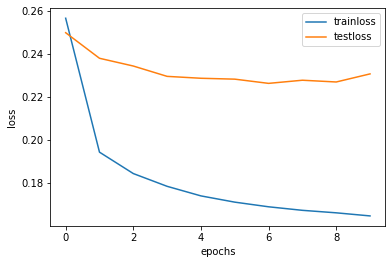

In [8]:
if True:
    stats=list()
    for epoch in range(10):
        trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
        testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
        metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
        msg = f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}"
        print(msg)

        #test_model(model, validdataset, device)

        model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
        pth = os.path.join(model_dir, model_name+".pth")
        print(f"saving model snapshot to {pth}")
        snapshot(model, optimizer, pth)
        stat = dict()
        stat["epoch"] = epoch
        for name, metric in testmetrics.items():
            stat[name]=metric.compute()

        stat["trainloss"] = trainloss.cpu().detach().numpy()
        stat["testloss"] = testloss.cpu().detach().numpy()
        stats.append(stat)

    df = pd.DataFrame(stats)

    fig,ax = plt.subplots()
    ax.plot(df.epoch, df.trainloss, label="trainloss")
    ax.plot(df.epoch, df.testloss, label="testloss")
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
else:
    from dataset import download_url
    url="https://syncandshare.lrz.de/download/MkxBRzlaTGJqS0J4RktaajN3djJB/model_weights/canada/LSTM_canada_l%3D3_h%3D32_e%3D9.pth"
    download_url(url,"/tmp/model.pth")
    #restore("/tmp/models/LSTM_canada_l=3_h=32_e=9.pth",model)
    restore("/tmp/model.pth",model)

saving to /home/marc/projects/igarss2020_tex/img/canada/canada


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c1c4adf28>,
       dtype=object))

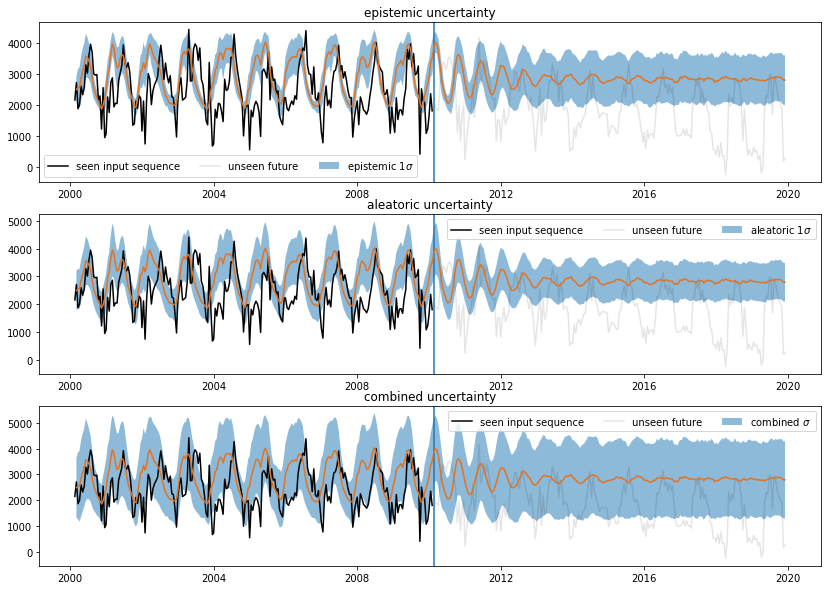

In [6]:
idx = 12
N_seen_points = 230#455
N_predictions = 100

x = testdataset.data[idx].astype(float)

finetuned_model = deepcopy(model)
optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=1e-2, weight_decay=1e-6)

finetuned_model = fine_tune(x[:N_seen_points], finetuned_model, criterion, optimizer, inner_steps=0)

date = testdataset.date[idx].astype(np.datetime64)

store="/home/marc/projects/igarss2020_tex/img/canada/canada"
#store=None

make_and_plot_predictions(finetuned_model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

In [ ]:
future = 50

finetuned_model = deepcopy(model)
optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=1e-2, weight_decay=1e-6)

finetuned_model = fine_tune(x, finetuned_model, criterion, optimizer, inner_steps=2)

fig,ax = plt.subplots(figsize=(12,4))
ax.yaxis.grid(which="major")
predict_future(finetuned_model, x, future, date, N_predictions=50, ax=ax, device=device, meanstd=(dataset.mean,dataset.std))


In [78]:
mean.shape

torch.Size([506])

In [76]:
all_dates.shape

(506,)

In [1]:
from visualizations import predict_future


ModuleNotFoundError: No module named 'visualizations'

In [55]:
future_dates

array(['2019-12-19', '2020-01-04', '2020-01-20', '2020-02-05',
       '2020-02-21', '2020-03-08', '2020-03-24', '2020-04-09',
       '2020-04-25', '2020-05-11'], dtype='datetime64[D]')

In [56]:
.shape

(466,)

In [53]:
mean.shape

torch.Size([1, 466, 1])